In [1]:
# Basic regression to predict fuel efficiency
# Code is based on this tutorial: https://www.tensorflow.org/tutorials/keras/regression
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd # pip install pandas

# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [2]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
# https://archive.ics.uci.edu/ml/datasets/Auto+MPG

In [3]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

dataset = pd.read_csv(url, names=column_names, na_values='?',
                      comment='\t', sep=' ', skipinitialspace=True)

In [4]:
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [5]:
# clean data
dataset = dataset.dropna()

# convert categorical 'Origin' data into one-hot data
origin = dataset.pop('Origin')
dataset['USA'] = (origin == 1)*1
dataset['Europe'] = (origin == 2)*1
dataset['Japan'] = (origin == 3)*1

In [6]:
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1,0,0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0,1,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1,0,0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1,0,0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1,0,0


In [7]:
# Split the data into train and test
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

print(dataset.shape, train_dataset.shape, test_dataset.shape)
train_dataset.describe().transpose()

(392, 10) (314, 10) (78, 10)


,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.310510,7.728652,10.0,17.00,22.0,28.95,46.6
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


In [8]:
# split features from labels
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

In [9]:
def plot(feature, x=None, y=None):
    plt.figure(figsize=(10, 8))
    plt.scatter(train_features[feature], train_labels, label='Data')
    if x is not None and y is not None:
        plt.plot(x, y, color='k', label='Predictions')
    plt.xlabel(feature)
    plt.ylabel('MPG')
    plt.legend()

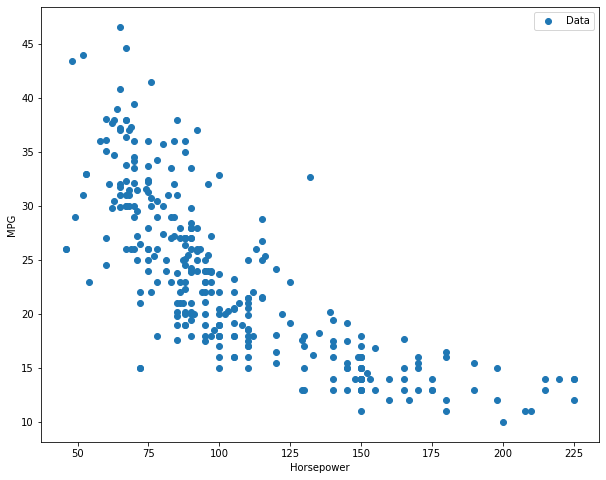

In [10]:
plot('Horsepower')

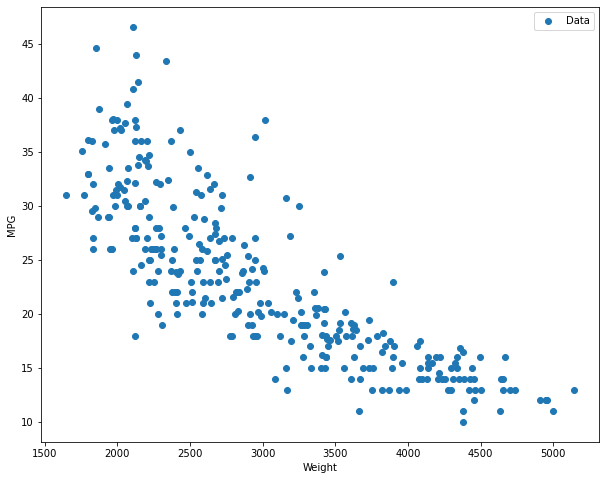

In [11]:
plot('Weight')

In [12]:
# Normalize
print(train_dataset.describe().transpose()[['mean', 'std']])

# Normalization
normalizer = preprocessing.Normalization()

# adapt to the data
normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy())

                     mean         std
MPG             23.310510    7.728652
Cylinders        5.477707    1.699788
Displacement   195.318471  104.331589
Horsepower     104.869427   38.096214
Weight        2990.251592  843.898596
Acceleration    15.559236    2.789230
Model Year      75.898089    3.675642
USA              0.624204    0.485101
Europe           0.178344    0.383413
Japan            0.197452    0.398712
[   5.478  195.318  104.869 2990.252   15.559   75.898    0.624    0.178
    0.197]


In [13]:
# When the layer is called it returns the input data, with each feature independently normalized:
# (input-mean)/stddev
first = np.array(train_features[:1])
print('First example:', first)
print('Normalized:', normalizer(first).numpy())

First example: [[   4.    90.    75.  2125.    14.5   74.     1.     0.     0. ]]
Normalized: [[-0.871 -1.011 -0.785 -1.027 -0.38  -0.517  0.776 -0.466 -0.496]]


In [14]:
# Regression
 # 1. Normalize the input horsepower
 # 2. Apply a linear transformation (y = m*x+b) to produce 1 output using layers.Dense

feature = 'Horsepower'
single_feature = np.array(train_features[feature])
print(single_feature.shape, train_features.shape)

# Normalization
single_feature_normalizer = preprocessing.Normalization()

# adapt to the data
single_feature_normalizer.adapt(single_feature)

(314,) (314, 9)


In [15]:
# Sequential model
single_feature_model = keras.models.Sequential([
    single_feature_normalizer,
    layers.Dense(units=1) # Linear Model
])

In [16]:
single_feature_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense (Dense)                (None, 1)                 2         
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [17]:
# loss and optimizer
loss = keras.losses.MeanAbsoluteError() # MeanSquaredError
optim = keras.optimizers.Adam(lr=0.1)

single_feature_model.compile(optimizer=optim, loss=loss)
history = single_feature_model.fit(
    train_features[feature], train_labels,
    epochs=100,
    verbose=1,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

C:\Users\ravid\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/100
8/8 [==============================] - 1s 36ms/step - loss: 22.8624 - val_loss: 22.9385
Epoch 2/100
8/8 [==============================] - 0s 6ms/step - loss: 22.0655 - val_loss: 22.1382
Epoch 3/100
8/8 [==============================] - 0s 5ms/step - loss: 21.2615 - val_loss: 21.3384
Epoch 4/100
8/8 [==============================] - 0s 5ms/step - loss: 20.4612 - val_loss: 20.5384
Epoch 5/100
8/8 [==============================] - 0s 6ms/step - loss: 19.6609 - val_loss: 19.7384
Epoch 6/100
8/8 [==============================] - 0s 6ms/step - loss: 18.8622 - val_loss: 18.9384
Epoch 7/100
8/8 [==============================] - 0s 5ms/step - loss: 18.0614 - val_loss: 18.1386
Epoch 8/100
8/8 [==============================] - 0s 5ms/step - loss: 17.2656 - val_loss: 17.3383
Epoch 9/100
8/8 [==============================] - 0s 5ms/step - loss: 16.4606 - val_loss: 16.5394
Epoch 10/100
8/8 [==============================] - 0s 5ms/step - loss: 15.6669 - val_loss: 15.7450
Epoch 11

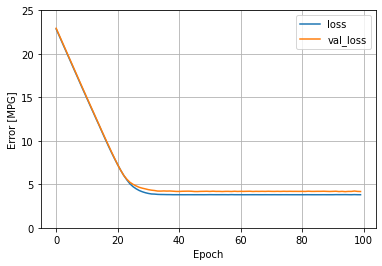

In [18]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 25])
    plt.xlabel('Epoch')
    plt.ylabel('Error [MPG]')
    plt.legend()
    plt.grid(True)
plot_loss(history)

In [19]:
single_feature_model.evaluate(
    test_features[feature],
    test_labels, verbose=1)

3/3 [==============================] - 0s 3ms/step - loss: 3.6499


3.6499366760253906

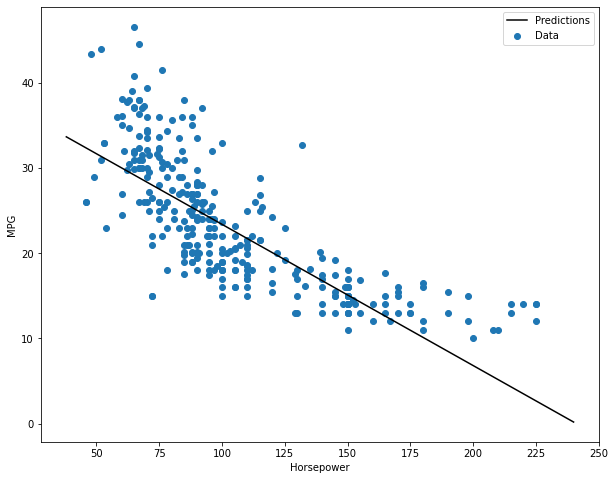

In [20]:
# predict and plot
range_min = np.min(test_features[feature]) - 10
range_max = np.max(test_features[feature]) + 10
x = tf.linspace(range_min, range_max, 200)
y = single_feature_model.predict(x)
    
plot(feature, x,y)

In [21]:
# DNN
dnn_model = keras.Sequential([
    single_feature_normalizer,
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])

In [22]:
dnn_model.compile(loss=loss, 
                  optimizer=tf.keras.optimizers.Adam(0.001))

dnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                128       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


In [23]:
dnn_model.fit(
    train_features[feature], train_labels,
    validation_split=0.2,
    verbose=1, epochs=100)

Epoch 1/100
8/8 [==============================] - 1s 28ms/step - loss: 23.1846 - val_loss: 23.5342
Epoch 2/100
8/8 [==============================] - 0s 6ms/step - loss: 22.8957 - val_loss: 23.2332
Epoch 3/100
8/8 [==============================] - 0s 5ms/step - loss: 22.5990 - val_loss: 22.8953
Epoch 4/100
8/8 [==============================] - 0s 6ms/step - loss: 22.2504 - val_loss: 22.4753
Epoch 5/100
8/8 [==============================] - 0s 5ms/step - loss: 21.8124 - val_loss: 21.9295
Epoch 6/100
8/8 [==============================] - 0s 6ms/step - loss: 21.2313 - val_loss: 21.2208
Epoch 7/100
8/8 [==============================] - 0s 6ms/step - loss: 20.4784 - val_loss: 20.3191
Epoch 8/100
8/8 [==============================] - 0s 6ms/step - loss: 19.5148 - val_loss: 19.2017
Epoch 9/100
8/8 [==============================] - 0s 6ms/step - loss: 18.3729 - val_loss: 17.9216
Epoch 10/100
8/8 [==============================] - 0s 6ms/step - loss: 17.1305 - val_loss: 16.5647
Epoch 11

In [24]:
dnn_model.evaluate(test_features[feature], test_labels, verbose=1)

3/3 [==============================] - 0s 3ms/step - loss: 2.9520


2.951990842819214

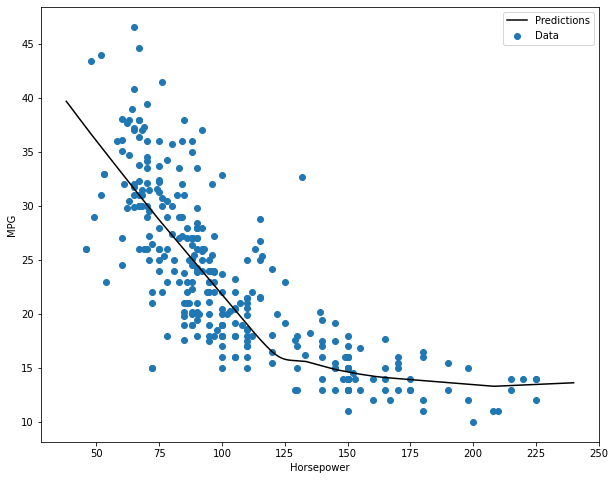

In [25]:

# predict and plot
x = tf.linspace(range_min, range_max, 200)
y = dnn_model.predict(x)

plot(feature, x,y)

In [26]:
# multiple inputs
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss=loss)

In [27]:
linear_model.fit(
    train_features, train_labels, 
    epochs=100,
    verbose=1,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

Epoch 1/100
8/8 [==============================] - 1s 25ms/step - loss: 22.9607 - val_loss: 22.9393
Epoch 2/100
8/8 [==============================] - 0s 5ms/step - loss: 22.0686 - val_loss: 22.2091
Epoch 3/100
8/8 [==============================] - 0s 6ms/step - loss: 21.2573 - val_loss: 21.4976
Epoch 4/100
8/8 [==============================] - 0s 5ms/step - loss: 20.4240 - val_loss: 20.7590
Epoch 5/100
8/8 [==============================] - 0s 6ms/step - loss: 19.6110 - val_loss: 20.0522
Epoch 6/100
8/8 [==============================] - 0s 5ms/step - loss: 18.8049 - val_loss: 19.3141
Epoch 7/100
8/8 [==============================] - 0s 5ms/step - loss: 17.9812 - val_loss: 18.5582
Epoch 8/100
8/8 [==============================] - 0s 6ms/step - loss: 17.1732 - val_loss: 17.8460
Epoch 9/100
8/8 [==============================] - 0s 6ms/step - loss: 16.3364 - val_loss: 17.1173
Epoch 10/100
8/8 [==============================] - 0s 5ms/step - loss: 15.5205 - val_loss: 16.3893
Epoch 11

In [28]:
linear_model.evaluate(
    test_features, test_labels, verbose=1)

3/3 [==============================] - 0s 2ms/step - loss: 2.5503


2.5502805709838867